In [1]:
import pandas as pd
import numpy as np
import math
import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from multiprocessing import Pool
seed = 42

In [2]:
from fastms.loading import load_samples

2022-11-14 11:53:50.652872: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-14 11:53:50.790969: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
samples = load_samples('/mnt/gc1610/home/msparams/stable_synth',0, 100000,-1)

In [6]:
X, X_seq, y = samples

In [54]:
features = np.concatenate([X_seq[:,0,0:1], X], axis = 1)
outputs = y[:,0,:]

In [55]:
n_features = features.shape[1]

In [56]:
idx_train, idx_test = train_test_split(
    np.arange(len(outputs)), #np.arange(100000),
    test_size=0.2,
    random_state=seed
)

In [21]:
import tensorflow as tf
from tensorflow.keras import Sequential, layers, Model

In [59]:
X_train = features[idx_train]
y_train = outputs[idx_train]#[:, :, np.newaxis]
X_test = features[idx_test]
y_test = outputs[idx_test]#[:, :, np.newaxis]

scaler = layers.Normalization()
scaler.adapt(X_train[:,:-365])

rainfall_scaler = layers.Normalization(axis=None)
rainfall_scaler.adapt(X_train[:,-365:])

In [35]:
def create_sequence_model(
    optimiser='adam',
    n_hidden=2,
    units=128,
    dropout=0.,
    loss='log_cosh',
    hidden_activation='relu',
    hidden_initialiser='he_normal',
    output_activation='linear',
    output_initialiser='glorot_normal',
    output_units=y_train.shape[2],
    output_time=y_train.shape[1]
):
    input_layer = layers.Input(shape=(n_features,), dtype='float32')
    input_encoding = scaler(input_layer)
    for i in range(n_hidden):
        input_encoding = layers.Dense(
            units,
            activation=hidden_activation,
            kernel_initializer=hidden_initialiser
        )(input_encoding)
        input_encoding = layers.Dropout(dropout)(input_encoding)
    output = tf.repeat(input_encoding[:, tf.newaxis, :], output_time, 1)
    for i in range(n_hidden):
        output = layers.LSTM(units, return_sequences=True)(output)
    output = layers.TimeDistributed(layers.Dense(output_units, activation=output_activation, kernel_initializer=output_initialiser))(output)
    model = Model(inputs = [input_layer], outputs = [output])
    model.compile(loss=loss, optimizer=optimiser, metrics='mse')
    return model

In [69]:
def create_model(
    optimiser='adam',
    n_hidden=3,
    units=288,
    dropout=.1,
    loss='log_cosh',
    hidden_activation='relu',
    hidden_initialiser='he_normal',
    output_activation='linear',
    output_initialiser='glorot_normal',
    n_outputs=y_train.shape[1]
):
    input_layer = layers.Input(shape=(n_features,), dtype='float32')
    scaled_input = scaler(input_layer[:,:-365])
    scaled_rainfall = rainfall_scaler(input_layer[:,-365:])
    scaled_input = tf.concat([scaled_input, scaled_rainfall], 1)
    model_output = scaled_input
    for i in range(n_hidden):
        model_output = layers.Dense(
            units,
            activation=hidden_activation,
            kernel_initializer=hidden_initialiser
        )(model_output)
        model_output = layers.Dropout(dropout)(model_output)
    model_output = layers.Dense(n_outputs, activation=output_activation, kernel_initializer=output_initialiser)(model_output)
    model = Model(inputs = [input_layer], outputs = [model_output])
    model.compile(loss=loss, optimizer=optimiser, metrics='mse')
    return model

In [70]:
model = create_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 371)]        0           []                               
                                                                                                  
 tf.__operators__.getitem_6 (Sl  (None, 6)           0           ['input_8[0][0]']                
 icingOpLambda)                                                                                   
                                                                                                  
 tf.__operators__.getitem_7 (Sl  (None, 365)         0           ['input_8[0][0]']                
 icingOpLambda)                                                                                   
                                                                                            

In [71]:
model.fit(X_train, y_train, batch_size=100, epochs=100)

Epoch 1/100
486/486 [==============================] - 2s 4ms/step - loss: 0.0253 - mse: 0.0545
Epoch 2/100
486/486 [==============================] - 2s 4ms/step - loss: 0.0143 - mse: 0.0290
Epoch 3/100
486/486 [==============================] - 2s 4ms/step - loss: 0.0135 - mse: 0.0274
Epoch 4/100
486/486 [==============================] - 2s 4ms/step - loss: 0.0132 - mse: 0.0267
Epoch 5/100
486/486 [==============================] - 2s 4ms/step - loss: 0.0130 - mse: 0.0263
Epoch 6/100
486/486 [==============================] - 2s 4ms/step - loss: 0.0128 - mse: 0.0260
Epoch 7/100
486/486 [==============================] - 2s 4ms/step - loss: 0.0127 - mse: 0.0258
Epoch 8/100
486/486 [==============================] - 2s 4ms/step - loss: 0.0126 - mse: 0.0255
Epoch 9/100
486/486 [==============================] - 2s 4ms/step - loss: 0.0126 - mse: 0.0255
Epoch 10/100
486/486 [==============================] - 2s 4ms/step - loss: 0.0124 - mse: 0.0252
Epoch 11/100
486/486 [=================

In [72]:
y_hat = model.predict(X_test)

380/380 [==============================] - 1s 2ms/step


Text(0, 0.5, 'true')

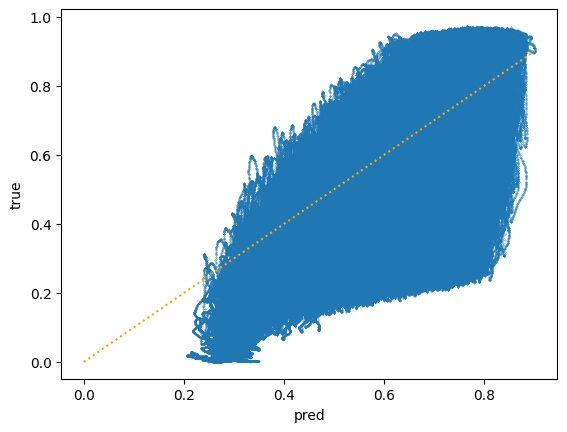

In [73]:
plt.scatter(y_hat.flatten(), y_test.flatten(), s=0.1)
plt.plot(np.linspace(0, 0.9), np.linspace(0, 0.9), linestyle=':', color='orange')
plt.xlabel('pred')
plt.ylabel('true')

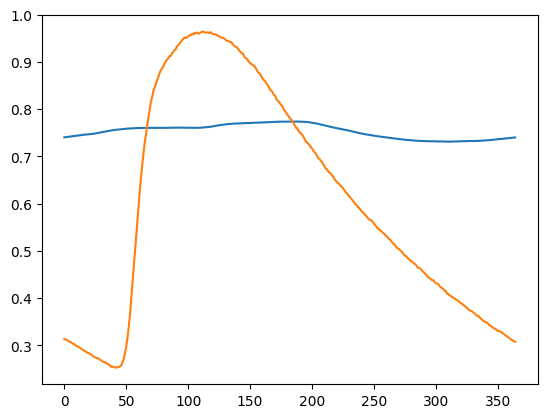

In [80]:
i = 3
plt.plot(range(365), y_hat[i,:])
plt.plot(range(365), y_test[i,:])

In [76]:
y_test.shape

(12146, 365)

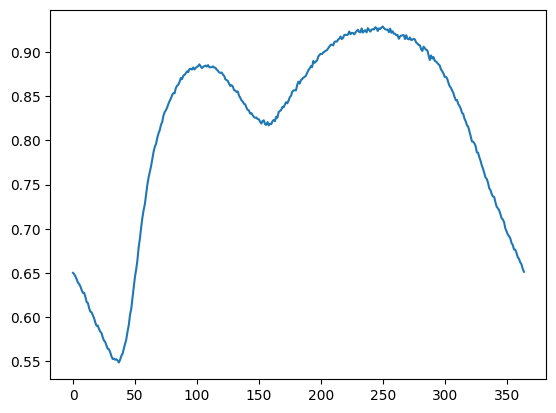

In [84]:
i=5
plt.plot(range(365), y_train[i,:])